## 1. Set Up

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00


In [1]:
#Am I running a GPU and what type is it?
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [10]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = torch.device("cpu")
     

No GPU available


In [34]:
from logging import warning
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint

import warnings
warnings.filterwarnings('ignore')


In [35]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

pd.set_option('display.max_colwidth', 100)
sns.set(style='whitegrid')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd drive/MyDrive/w266

/content/drive/MyDrive/w266


In [ ]:
# !git clone https://github.com/hjesse92/style_transfer_w266.git

Cloning into 'style_transfer_w266'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 2), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), 90.27 KiB | 355.00 KiB/s, done.


In [6]:
cd style_transfer_w266/

/content/drive/MyDrive/w266/style_transfer_w266


In [7]:
# !git checkout -b eda_basemodel
!git branch

* eda_basemodel
  main


In [8]:
!ls data/

original-dev.tsv  original-test.tsv  original-train.tsv


## 2. EDA

In [9]:
train_text_file = 'data/original-train.tsv'
dev_text_file = 'data/original-dev.tsv'
test_text_file = 'data/original-test.tsv'

In [63]:
def load_data(text_file):
  """Load data and rename column"""
  df = pd.read_csv(text_file, sep="\t")
  df = df.rename(columns={'offensive-text':'org', 'style-transferred-text': 'mod'})
  
  # Calculate text length / word counts
  df['org_text_length'] = df['org'].apply(lambda x: len(x.split(' ')))
  df['mod_text_length'] = df['mod'].apply(lambda x: len(x.split(' ')))

  return df

In [105]:
def modify_text_to_print(df):
  """Modify some toxic, offensive texts in the datafram for printing out"""
  df["org"] = df["org"].apply(lambda x: x.lower().replace('fuck', 'f***')\
                              .replace('shit', 's***')\
                              .replace('pussy', 'p***y'))

  return df

In [106]:
train_df = load_data(train_text_file)
dev_df = load_data(dev_text_file)
test_df = load_data(test_text_file)

print('Train data size:', train_df.shape[0])
print('Dev data size:', dev_df.shape[0])
print('Test data size:', test_df.shape[0])

print('\nTrain data overview:')
modify_text_to_print(train_df)

Train data size: 1584
Dev data size: 198
Test data size: 199

Train data overview:


,org,mod,org_text_length,mod_text_length
0,p*ssy nobody asked for your input.,Nobody asked for your input,6,5
1,"ok, this makes no sense. this will create vigilantes. and i hope they put this savage animal dow...","Ok, this makes no sense. This will create vigilantes. And I hope they take care of this uncontro...",23,24
2,so f**king true. the amount of up and coming rappers that are shot dead or od is is so f**king s...,so true. the amount of up and coming rappers that are shot dead or od is is so sad.,23,19
3,go f yourself republican scum who put us here with your uneducated voting like you even care. i ...,Republicans put us in this situation. I would want to defund the police.,23,13
4,dumb f**king take. people want to do things.,That's not a smart take. People want to do things.,8,10
...,...,...,...,...
1579,"the view! and this crap hits my front page!? lmfao i know it's mostly bots but still, /r/polit...","This must be mostly bots but still, it's strange for /r/politics.",22,11
1580,that’s racist.,Those actions are racist.,2,4
1581,cultural marxism isn't a thing you weird f**k.,Cultural Marxism isn't a thing.,8,5
1582,"lol, anyone that questions the democrat program is always a russian asset or nazi. this sh*ts ol...","LOL, anyone that questions the Democrat program is always considered back. This is getting old, ...",21,19


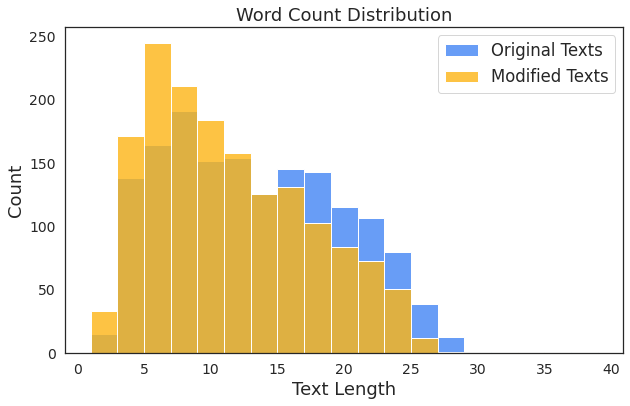

In [87]:
### Plot the word-count distribution for the original texts and the modified texts.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')

# calculate the bin size based on the range of the data
bins = range(min(train_df['org_text_length'].min(), train_df['mod_text_length'].min()), 
             max(train_df['org_text_length'].max(), train_df['mod_text_length'].max()) + 2, 2)

# plot the histograms with the same bin size
sns.histplot(data=train_df, x='org_text_length', label='Original Texts', bins=bins, color='#4285F4', alpha=0.8)
sns.histplot(data=train_df, x='mod_text_length', label='Modified Texts', bins=bins, color='#FDB515', alpha=0.8)

# set the axis labels and title
ax.set(xlabel='Text Length', ylabel='Count')
ax.set_title('Word Count Distribution', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)
plt.legend(loc='upper right')

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [110]:
### Find out what words appear the most in the original texts and the modified text without including stopwords
from collections import Counter
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

# create a list of stopwords
stop_words = set(stopwords.words('english')) | {"i'm", "you’re", "that's"}
# print(stop_words)

# create a list of all words in the 'org' column, removing stopwords
org_words = ' '.join(train_df['org']).lower().split()
org_words = [word.strip(".,?!:").replace('fuck', 'f***').replace('shit', 's***') for word in org_words if word not in stop_words]
# org_words = [word.lower() for word in train_df['org'].str.split() if word.lower() not in stop_words]

# create a list of all words in the 'mod' column, removing stopwords
mod_words = ' '.join(train_df['mod']).lower().split()
mod_words = [word.strip(".,?!:") for word in mod_words if word not in stop_words]
# mod_words = [word.lower() for word in train_df['mod'].str.split() if word.lower() not in stop_words]

# count the frequency of each word in the 'org' column
org_word_counts = Counter(org_words)

# count the frequency of each word in the 'mod' column
mod_word_counts = Counter(mod_words)

# create a pandas dataframe of the top 20 most common words in each column
top_org_words = pd.DataFrame(org_word_counts.most_common(20), columns=['word', 'count'])
top_mod_words = pd.DataFrame(mod_word_counts.most_common(20), columns=['word', 'count'])

# print the top 20 most common words in each column
print("Top 20 most frequent words in the Original Texts:")
print(top_org_words)
print("\nTop 20 most frequent words in the Modified Texts:")
print(top_mod_words)

Top 20 most frequent words in the Original Texts:
       word  count
0      f**k    170
1      sh*t    158
2   f**king    138
3      like    119
4    people     90
5    stupid     84
6       get     78
7      dumb     57
8      even     52
9      know     52
10    think     52
11      lol     51
12    idiot     50
13       go     48
14      one     45
15   really     43
16      ass     43
17   racist     42
18     good     42
19    right     38

Top 20 most frequent words in the Modified Texts:
      word  count
0   people    129
1     like    104
2      get     78
3    think     67
4   really     58
5     know     52
6   person     51
7     good     49
8     make     48
9     stop     47
10    even     46
11     one     46
12    need     46
13      go     45
14     bad     44
15      it     43
16   would     37
17     lol     35
18  racist     34
19   stuff     34


In [16]:
# from datasets import load_dataset
# train_ds = load_dataset("csv", data_files=train_text_file, sep="\t", names=["org","mod"])
# train_ds
# print(train_ds["train"][:5])

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['org', 'mod'],
        num_rows: 1585
    })
})

{'org': ['offensive-text', 'Pussy nobody asked for your input.', 'Ok, this makes no sense. This will create vigilantes. And I hope they put this savage animal down before he hurts anyone else.', 'so fucking true. the amount of up and coming rappers that are shot dead or od is is so fucking sad yet hillarious.', 'Go f yourself Republican scum who put us here with your uneducated voting like you even care. I do want to defund police.'], 'mod': ['style-transferred-text', 'Nobody asked for your input', 'Ok, this makes no sense. This will create vigilantes. And I hope they take care of this uncontrollable person before he hurts anyone else', 'so true. the amount of up and coming rappers that are shot dead or od is is so sad.', 'Republicans put us in this situation. I would want to defund the police.']}
